# Building a multivariate time series model with darts

In [13]:
from darts import TimeSeries
import pandas as pd
from definitions import MEASUREMENTS, TARGETS
from darts.dataprocessing.transformers import Scaler, BoxCox
from darts.models import RNNModel
import matplotlib.pyplot as plt
from darts.metrics import mape, smape
import pickle
from pyprocessta.preprocess.resample import resample_regular

MEAS_COLUMNS =[ 'PI-2', 'TI-2', 'FI-2', 'PI-3', 'TI-3', 'CO2-3', 'O2-3',
       'TI-32', 'TI-33', 'TI-34', 'TI-35', 'PI-4', 'TI-4', 'FI-4', 'CO2-4',
       'NH3-4', 'FI-11', 'TI-12', 'TI-13', 'FI-20', 'FI-211', 'TI-211', 'TI-8',
       'TI-9', 'TI-5', 'TI-7', 'TI-28', 'PI-28', 'PI-30', 'TI-30', 'FI-30',
       'FI-38', 'PI-38', 'FI-36', 'TI-36', 'Reboiler duty', 'FI-19', 'TI-19',
       'PI-1', 'TI-1',  'FI-35', 'TI-39', 'FI-23', 'TI-22',
       'Level Desorber', 'Level Reboiler', 'TI-24', 'TI-25', 'FI-25', 'FI-16',
       'TI-16', 'FI-151', 'TI-151', 'TI-152', 'TI-212', 'FI-241', 'TI-241',
       'TI-242', 'valve-position-12', 'TI-1213']

In [2]:
df = pd.read_pickle('detrended.pkl')

In [3]:
df = resample_regular(df, '5min')

In [4]:
TARGETS

['Carbon dioxide CO2',
 '2-Amino-2-methylpropanol C4H11NO',
 'Piperazine C4H10N2',
 'Ammonia NH3']

In [51]:
y = TimeSeries.from_dataframe(df, value_cols=TARGETS[2])

In [52]:
x = TimeSeries.from_dataframe(df, value_cols=MEAS_COLUMNS)

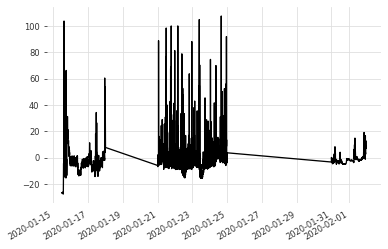

In [53]:
y.plot()

In [54]:
y_train, _ = y.split_before(pd.Timestamp('2020-01-25 12:59:15'))
x_train, _ = x.split_before(pd.Timestamp('2020-01-25 12:59:15'))

In [55]:
_, y_test = y.split_after(pd.Timestamp('2020-01-31 02:59:15'))
_, x_test = x.split_after(pd.Timestamp('2020-01-31 02:59:15'))

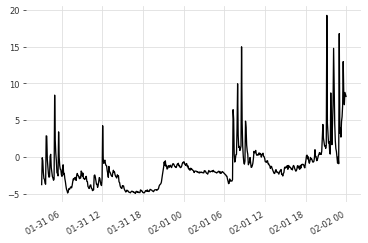

In [56]:
y_test.plot()

In [57]:
transformer = Scaler()
y_transformer = Scaler()
bc = BoxCox()

x_train = transformer.fit_transform(x_train)
x_test = transformer.transform(x_test)


y_train = y_transformer.fit_transform(y_train)
y_test = y_transformer.transform(y_test)


In [58]:
with open('x_scaler.pkl', 'wb') as handle:
    pickle.dump(transformer, handle)
    
with open('pip_scaler.pkl', 'wb') as handle:
    pickle.dump(y_transformer, handle)

### RNN model

In [78]:
model_cov = RNNModel(model='GRU',
    input_chunk_length=4,
    output_chunk_length=1,
    hidden_size=6,
    n_rnn_layers=6,
    dropout=0.3,
    batch_size=32,
    n_epochs=300,
    optimizer_kwargs={'lr': 1e-5})

In [79]:
model_cov.fit(series=y_train,
              covariates=x_train,
              verbose=True)

[2021-04-09 10:25:55,519] INFO | darts.models.torch_forecasting_model | Train dataset contains 2892 samples.
[2021-04-09 10:25:55,519] INFO | darts.models.torch_forecasting_model | Train dataset contains 2892 samples.


Training loss: 0.0074


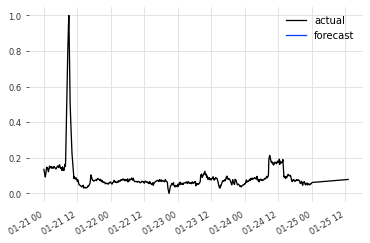

In [20]:
pred_cov = model_cov.predict(n=1,
                             series=y_train,
                             covariates=x_train)

y_train.plot(label='actual')
pred_cov.plot(label='forecast')
plt.legend();


MAPE (using covariates) = 22.44%


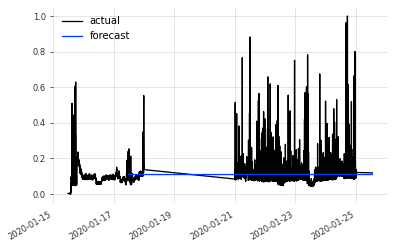

In [165]:
backtest_cov = model_cov.historical_forecasts(y_train,
                                              covariates=x_train,
                                              start=0.2,
                                              forecast_horizon=1,
                                              stride=1,
                                              retrain=False,
                                              verbose=True)

y_train.plot(label='actual')
backtest_cov.plot(label='forecast')
plt.legend();
print('MAPE (using covariates) = {:.2f}%'.format(mape(y_train, backtest_cov)))


MAPE (using covariates) = 646.67%


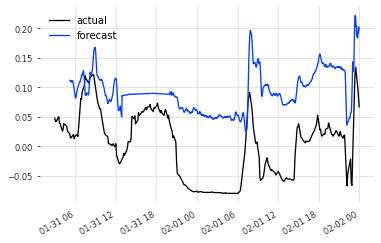

In [14]:
backtest_cov = model_cov.historical_forecasts(y_test,
                                              covariates=x_test,
                                              start=0.05,
                                              forecast_horizon=1,
                                              stride=1,
                                              retrain=False,
                                              verbose=True)

y_test.plot(label='actual')
backtest_cov.plot(label='forecast')
plt.legend();
print('MAPE (using covariates) = {:.2f}%'.format(mape(y_test, backtest_cov)))


MAPE (using covariates) = 11.35%


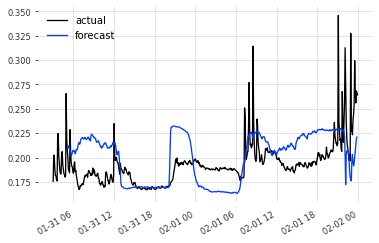

In [61]:
backtest_cov = model_cov.historical_forecasts(y_test,
                                              covariates=x_test,
                                              start=0.05,
                                              forecast_horizon=1,
                                              stride=1,
                                              retrain=False,
                                              verbose=True)

y_test.plot(label='actual')
backtest_cov.plot(label='forecast')
plt.legend();
print('MAPE (using covariates) = {:.2f}%'.format(mape(y_test, backtest_cov)))

In [72]:
x_train.copy().time_index()

DatetimeIndex(['2020-01-15 11:42:01', '2020-01-15 11:47:01',
               '2020-01-15 11:52:01', '2020-01-15 11:57:01',
               '2020-01-15 12:02:01', '2020-01-15 12:07:01',
               '2020-01-15 12:12:01', '2020-01-15 12:17:01',
               '2020-01-15 12:22:01', '2020-01-15 12:27:01',
               ...
               '2020-01-25 12:12:01', '2020-01-25 12:17:01',
               '2020-01-25 12:22:01', '2020-01-25 12:27:01',
               '2020-01-25 12:32:01', '2020-01-25 12:37:01',
               '2020-01-25 12:42:01', '2020-01-25 12:47:01',
               '2020-01-25 12:52:01', '2020-01-25 12:57:01'],
              dtype='datetime64[ns]', length=2896, freq='5T')

In [77]:
y_train.pd_dataframe().shape

(2896, 1)

In [18]:
import pickle

In [31]:
with open('pip_model.pkl', 'wb') as handle:
    pickle.dump(model_cov, handle)

### Transformer model

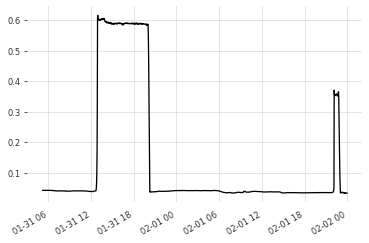

In [73]:
backtest_cov['3'].plot()

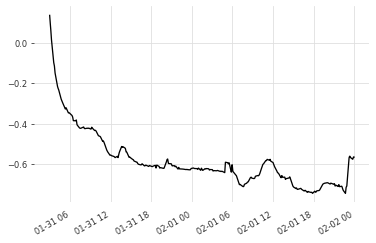

In [74]:
y_test['3'].plot(label='actual')